![logo](https://www.databolt.tech/images/logo.png)
Accelerate data science [www.databolt.tech](https://www.databolt.tech) | [github.com/d6t/d6t-python](https://github.com/d6t/d6t-python)


# DATA SCIENCE PROJECT TEMPLATES

## Classification for synthetic imbalanced dataset
## With oversampling option, implemented using SMOTE
SMOTE method reference: https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html

Created by Jiaxin Zhang on 12/18/2020

In [15]:
# processing
import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib
from luigi.util import inherits
# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.metrics import classification_report
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
import lightgbm

import shap

from imblearn.over_sampling import SMOTE



## preprocessing

In [16]:
%%capture

import d6tflow.pipes

d6tflow.pipes.init('oversampling',profile='default', reset=True,local_pipe=True)

In [17]:
pipe = d6tflow.pipes.get_pipe()
#pipe.pull()
print('where files are stored:',pipe.dirpath)

where files are stored: /Users/zhangjiaxin/d6tpipe/files/default/oversampling


In [56]:
class GenerateData(d6tflow.tasks.TaskPqPandas):
    '''
    Generate imbalanced classification data with user defined noise rate. 
    '''
    noise_ratio = luigi.Parameter(default = 0.01)  #The fraction of samples whose class is assigned randomly. 
    #simulate imbalanced data
    def run(self):        
        trainX, trainY = sklearn.datasets.make_classification(n_samples=1000, n_features=50, 
                                                              n_informative=2, n_repeated=0, 
                                                              n_classes=2, weights=(0.97,), 
                                                              class_sep=0.5, random_state=0,
                                                              flip_y = self.noise_ratio)
        df_trainX = pd.DataFrame(data = trainX)
        df_trainY = pd.DataFrame(data = trainY,columns = ['Y'])
        df_trainX.columns = [f'col{i}' for i in df_trainX.columns]
        df = pd.concat([df_trainX, df_trainY], axis=1, sort=False)
        self.save(df)
        
@d6tflow.requires(GenerateData) # define dependency
class TaskPreprocess(d6tflow.tasks.TaskCachePandas):
    '''
    Split train and test set, allow user to turn on oversampling technique (SMOTE) on training set
    '''
    oversampling = luigi.BoolParameter(default = False) #run on SMOTE on training set
    split_ratio = luigi.Parameter(default = 0.33) 
    
    def run(self):
        data = self.input().load() # quickly load required data
        df_train, df_test = train_test_split(data, test_size = self.split_ratio)
        if self.oversampling:
            trainX = df_train.iloc[:,:-1]
            trainY = df_train['Y']
            sm = SMOTE(random_state=42, k_neighbors= 6)
            X_res, y_res = sm.fit_resample(trainX, trainY)
            df_train = pd.concat([X_res, y_res], axis=1, sort=False)
            
        self.save({'train':df_train, 'test': df_test})  


In [57]:
#get training data with SMOTE
d6tflow.run(GenerateData(noise_ratio = '0.5')) #control the noise
params = {'oversampling':True,'split_ratio': 0.33 }
d6tflow.run(TaskPreprocess(**params)) # execute task with dependencies
result = TaskPreprocess(**params).output().load() # load output data
df_train_SMOTE = result['train']
df_test = result['test']


===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 GenerateData(noise_ratio=0.5)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====


===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 TaskPreprocess(noise_ratio=0.01, oversampling=True, split_ratio=0.33)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [58]:
#Get a training data without SMOTE
params_2 = {'do_preprocess':True, 'oversampling':False}
d6tflow.run(TaskPreprocess(**params_2)) # execute task with dependencies
df_train = TaskPreprocess(**params_2).output().load()['train']


===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 TaskPreprocess(noise_ratio=0.01, oversampling=False, split_ratio=0.33)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [59]:
print('size of training data without oversampling', df_train.shape)
print('size of training data with oversampling', df_train_SMOTE.shape)
print('size of testing set', df_test.shape)

size of training data without oversampling (670, 51)
size of training data with oversampling (1302, 51)
size of testing set (330, 51)


## data overview

In [27]:
df_train.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,Y
717,-0.126870,-0.408217,-1.308726,-1.100872,-0.244164,-1.132416,0.709522,-0.082634,0.140312,-0.088320,...,-1.185797,0.615272,0.017545,0.560241,-0.408446,-0.631064,0.246880,-1.699841,0.308828,0
174,-1.040431,-1.733583,-1.383625,-2.727706,0.563897,0.971664,2.106359,-0.631393,0.426900,1.069281,...,0.608071,1.553225,-0.426143,1.027750,-0.776161,-0.250530,0.062810,-0.878762,-1.719033,0
570,0.491517,-1.413693,-0.586558,0.532316,-0.987885,-0.594695,0.167424,-0.699563,1.376203,-0.584051,...,0.142980,-1.891359,0.000934,0.435922,0.231261,0.787484,-0.335682,1.763483,-1.044768,0
714,0.802342,-0.746111,-0.403467,-2.189290,0.204461,-1.482094,-1.659163,0.942410,-1.399626,-0.937891,...,-2.493290,1.507130,-0.517214,0.156409,-0.375348,0.814234,0.925865,1.425200,1.857989,1
842,-1.623300,-2.257168,1.069635,-0.145432,-1.188881,-0.748424,0.302537,-0.596673,0.085555,-0.058434,...,0.101635,0.685859,0.179895,-0.226717,1.048914,0.792015,0.915340,-0.995609,-0.014118,0


In [28]:
print('missing values')
df_train.isna().sum().sum()

missing values


0

In [29]:
print('unique values')
df_train.apply(lambda x: len(x.unique()))

unique values


col0     670
col1     670
col2     670
col3     670
col4     670
col5     670
col6     670
col7     670
col8     670
col9     670
col10    670
col11    670
col12    670
col13    670
col14    670
col15    670
col16    670
col17    670
col18    670
col19    670
col20    670
col21    670
col22    670
col23    670
col24    670
col25    670
col26    670
col27    670
col28    670
col29    670
col30    670
col31    670
col32    670
col33    670
col34    670
col35    670
col36    670
col37    670
col38    670
col39    670
col40    670
col41    670
col42    670
col43    670
col44    670
col45    670
col46    670
col47    670
col48    670
col49    670
Y          2
dtype: int64

In [30]:
df_train.describe().round(2)

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,Y
count,670.00,670.00,670.00,670.00,670.00,670.00,670.00,670.00,670.00,670.00,...,670.00,670.00,670.00,670.00,670.00,670.00,670.00,670.00,670.00,670.00
mean,0.01,-0.02,-0.08,-0.01,0.02,0.01,-0.04,-0.46,0.06,-0.06,...,0.01,0.01,0.01,-0.04,-0.01,-0.07,-0.01,-0.04,0.04,0.03
std,1.03,0.97,1.00,1.03,0.93,1.04,0.99,0.61,1.02,0.97,...,1.01,0.99,1.00,1.00,0.98,1.00,1.03,0.95,1.02,0.18
min,-2.80,-2.92,-3.01,-3.38,-2.79,-3.18,-3.69,-2.44,-2.92,-3.99,...,-3.05,-3.43,-3.77,-2.98,-2.82,-2.96,-2.97,-3.27,-3.12,0.00
25%,-0.68,-0.68,-0.74,-0.69,-0.56,-0.68,-0.70,-0.70,-0.62,-0.68,...,-0.67,-0.62,-0.62,-0.67,-0.63,-0.73,-0.65,-0.70,-0.66,0.00
50%,-0.02,-0.05,-0.10,0.03,0.09,-0.05,-0.03,-0.48,0.03,-0.07,...,0.01,0.03,0.05,-0.02,-0.03,-0.03,0.03,-0.02,0.07,0.00
75%,0.72,0.64,0.58,0.68,0.63,0.70,0.64,-0.27,0.71,0.60,...,0.71,0.68,0.68,0.65,0.61,0.62,0.69,0.59,0.70,0.00
max,2.92,3.02,3.14,3.09,2.46,3.24,2.88,2.10,3.80,3.83,...,3.61,3.47,3.51,2.76,3.60,3.00,2.98,3.13,3.43,1.00


### distribution of target variable

Text(0.5, 1.0, 'Y')

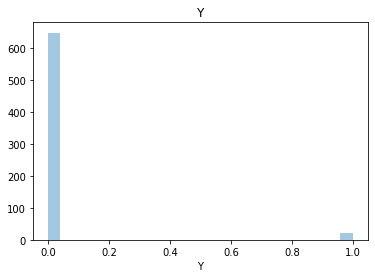

In [31]:
sns.distplot(df_train['Y'],kde = False).set_title('Y')
#We can see the original data was highly imbalanced

Text(0.5, 1.0, 'Y')

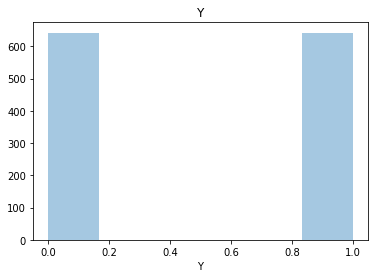

In [32]:
sns.distplot(df_train_SMOTE['Y'],kde = False).set_title('Y')
#after SMOTE, the data become balanced

### distribution of input variables

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

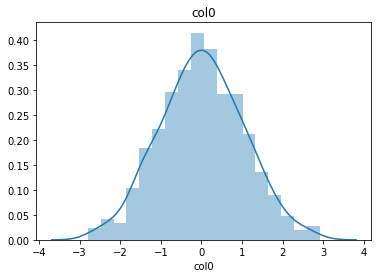

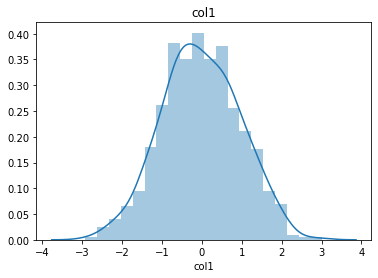

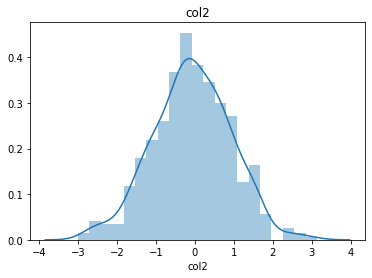

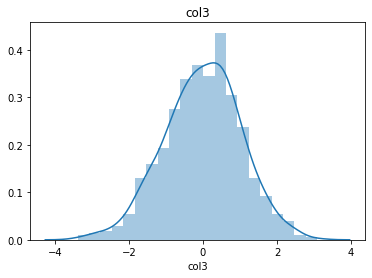

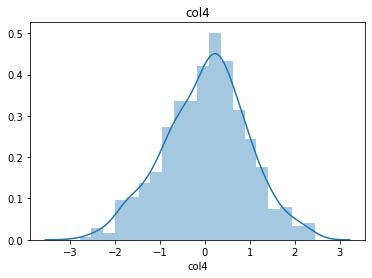

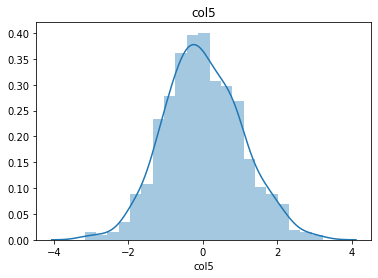

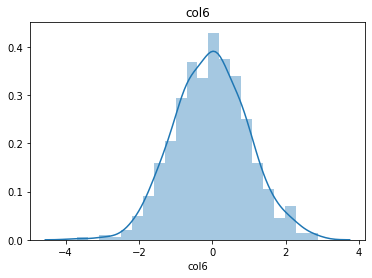

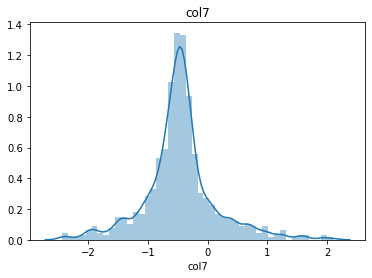

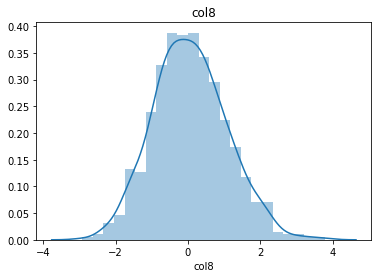

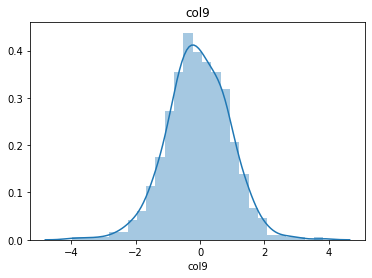

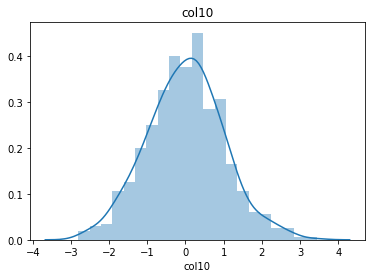

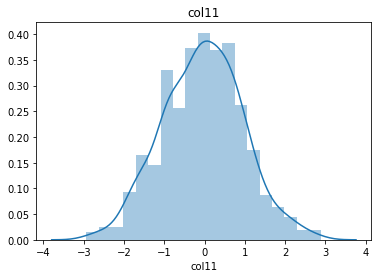

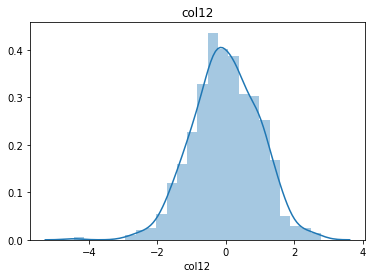

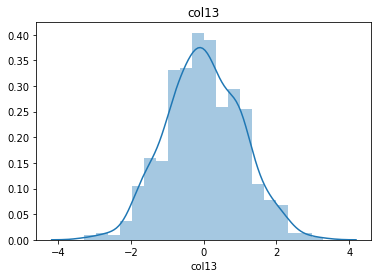

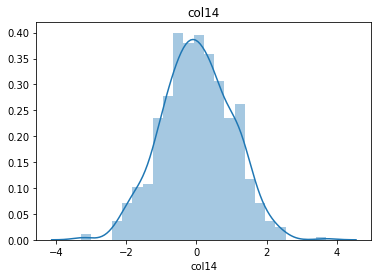

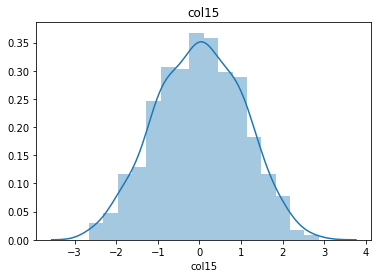

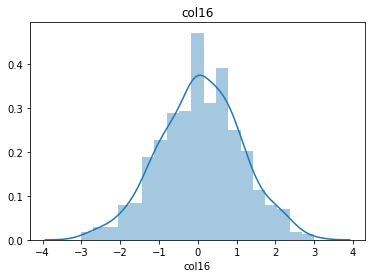

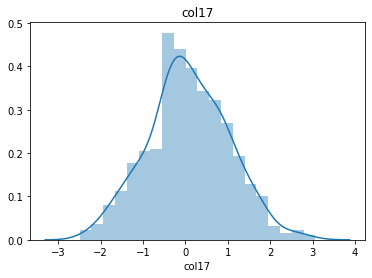

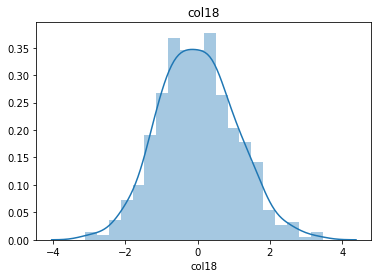

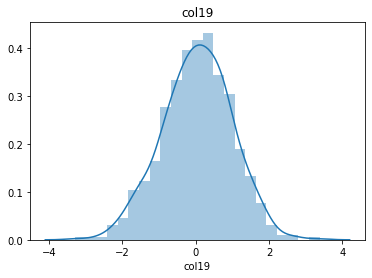

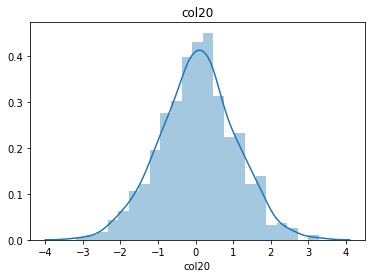

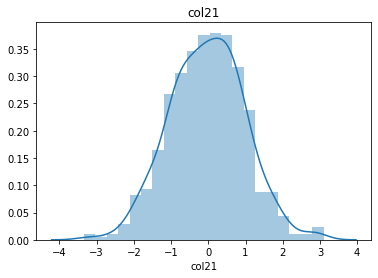

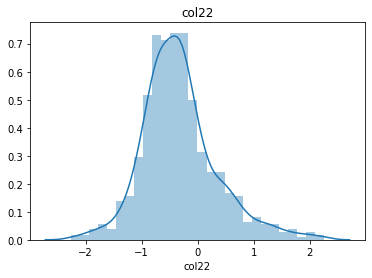

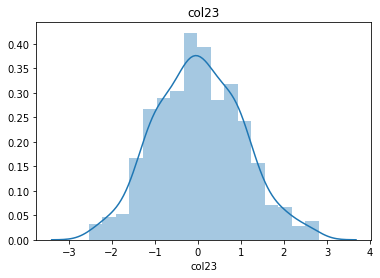

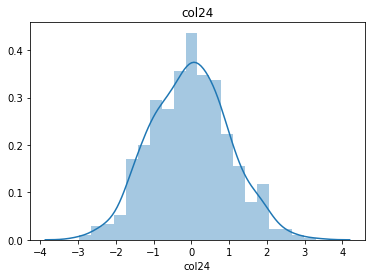

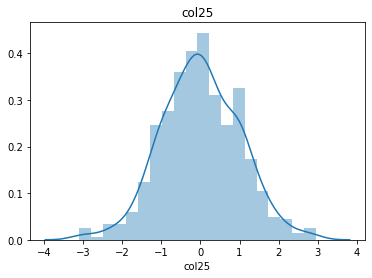

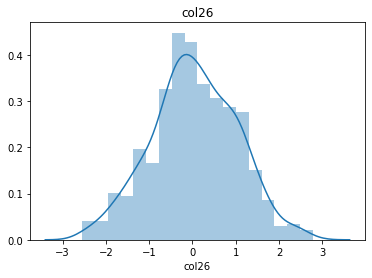

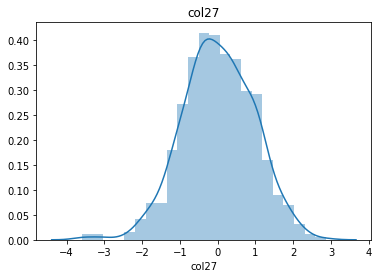

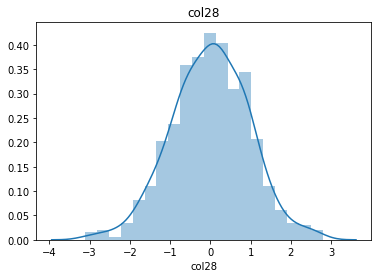

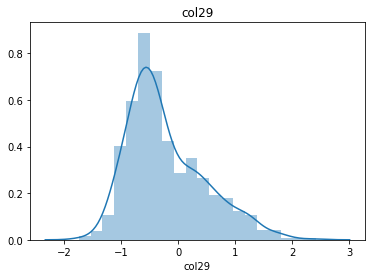

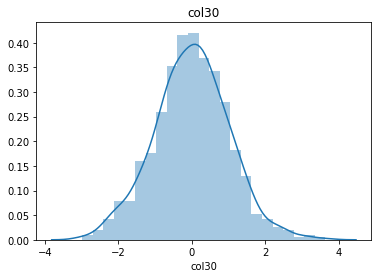

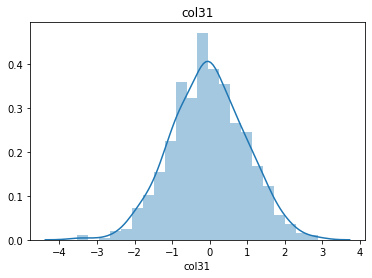

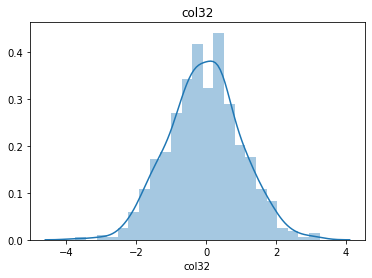

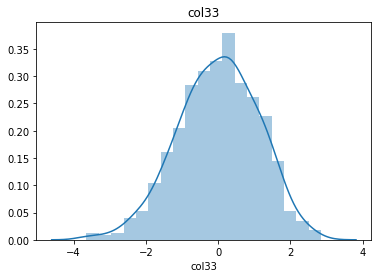

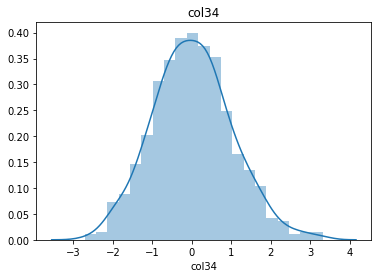

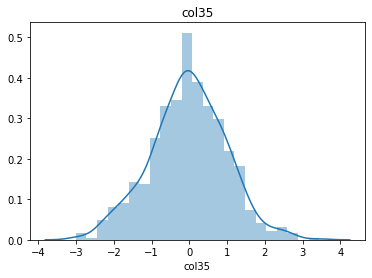

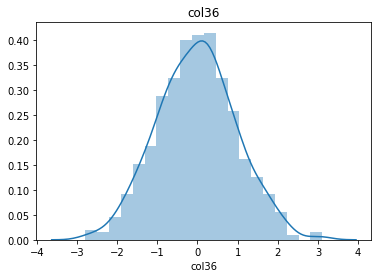

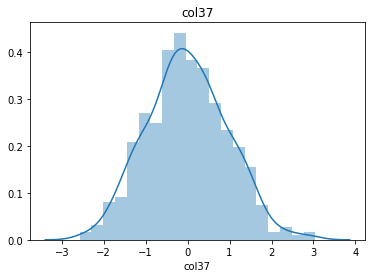

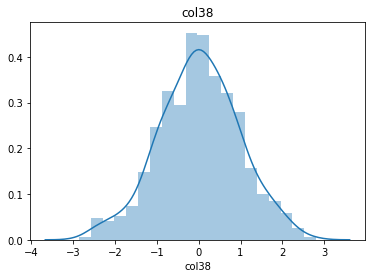

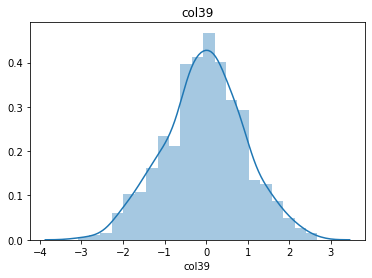

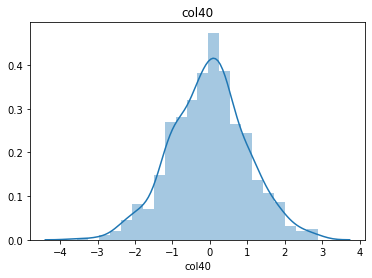

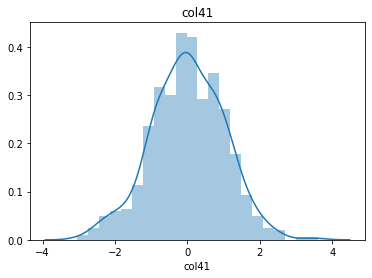

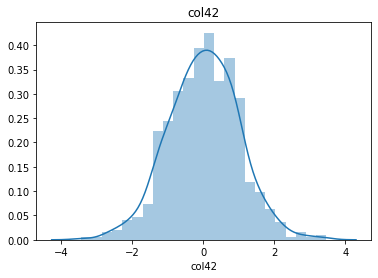

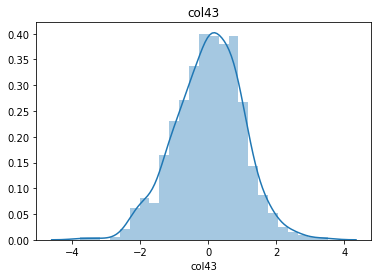

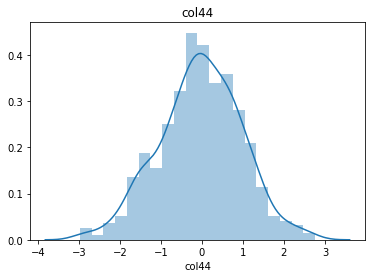

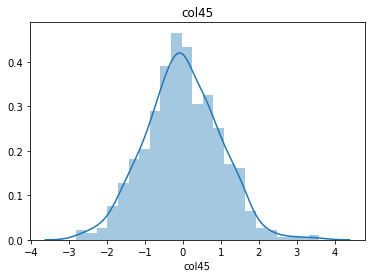

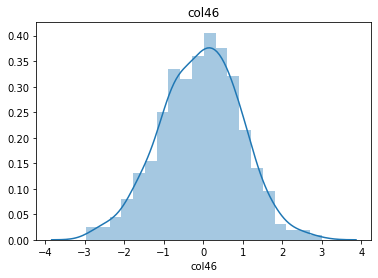

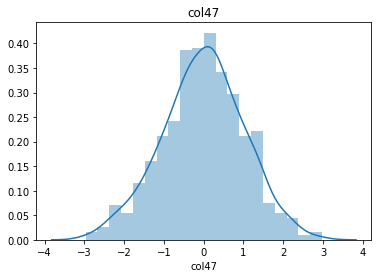

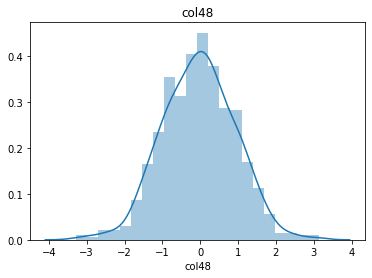

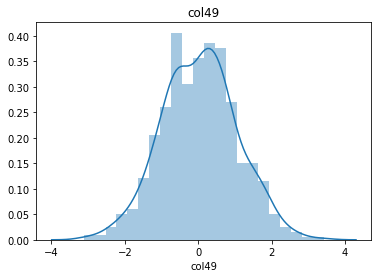

In [33]:
for icol in df_train.columns[:-1]:
    plt.figure();
    sns.distplot(df_train[icol]).set_title(icol);

### relation of inut variables to target variable

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


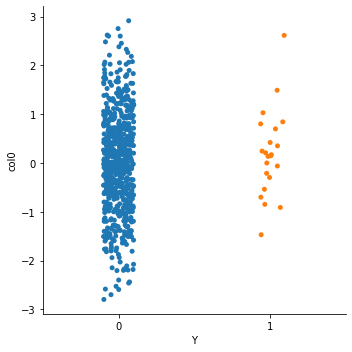

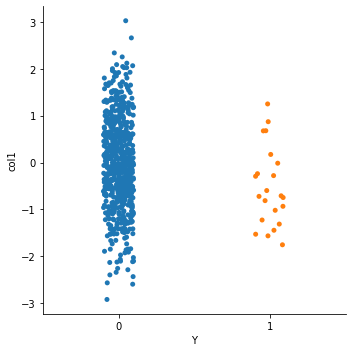

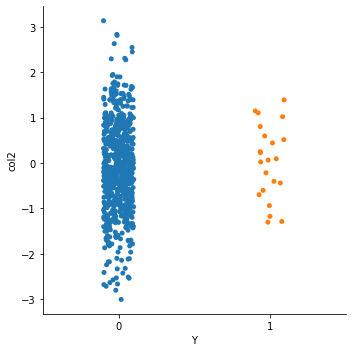

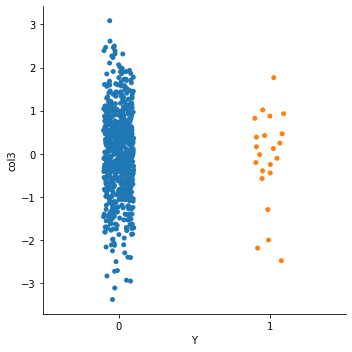

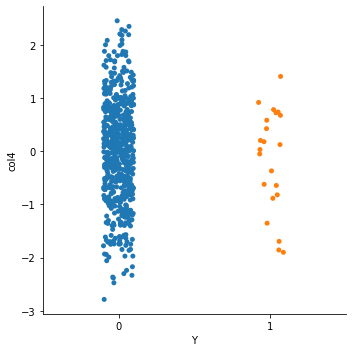

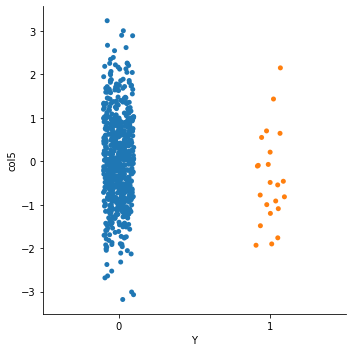

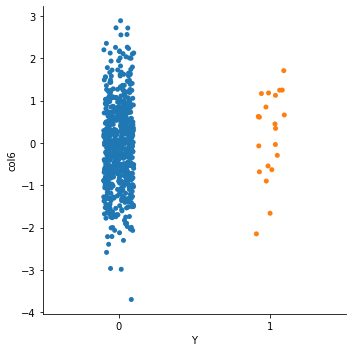

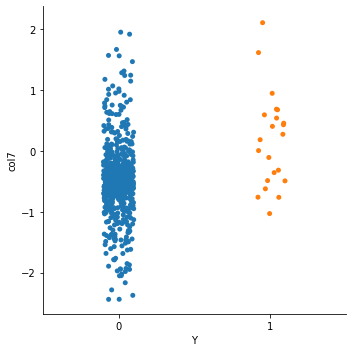

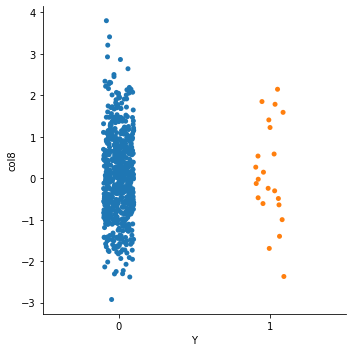

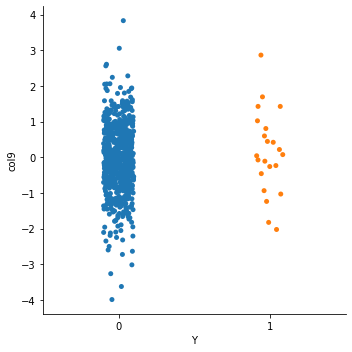

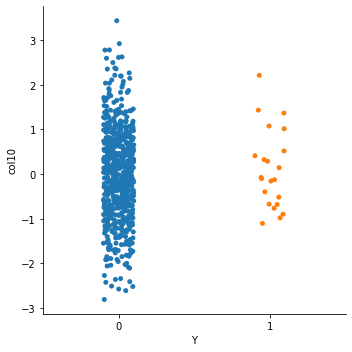

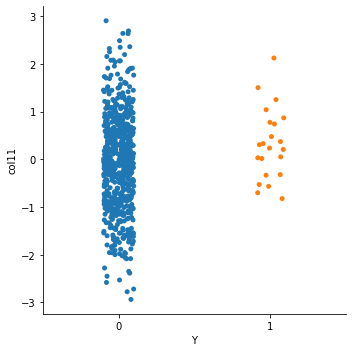

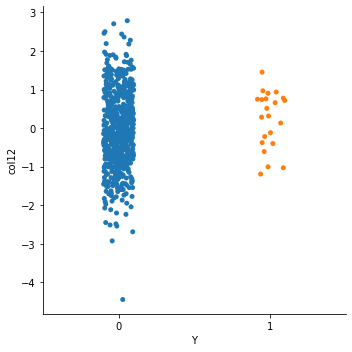

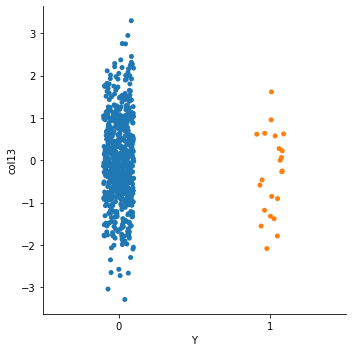

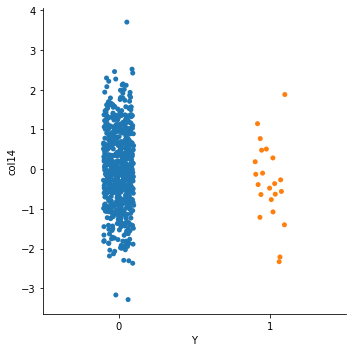

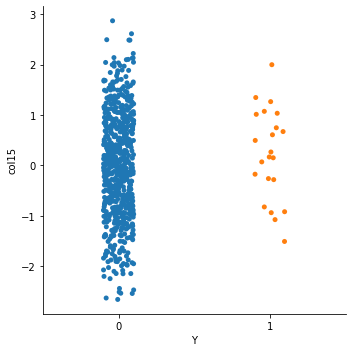

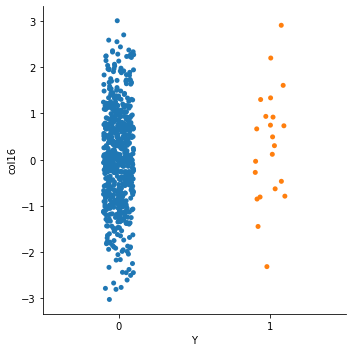

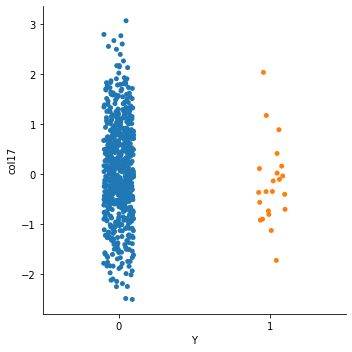

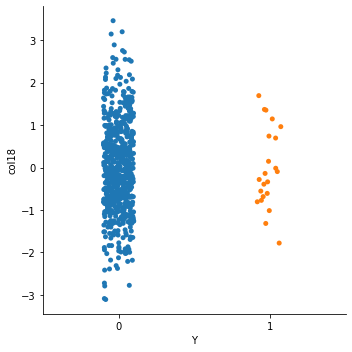

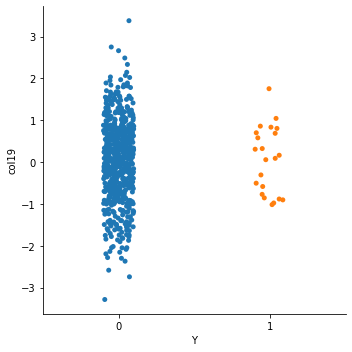

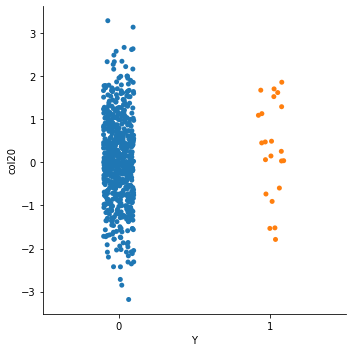

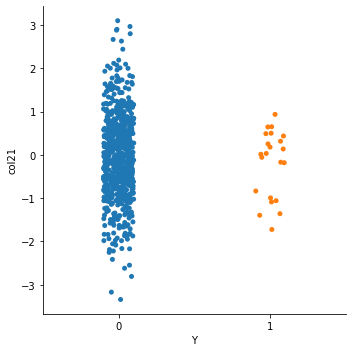

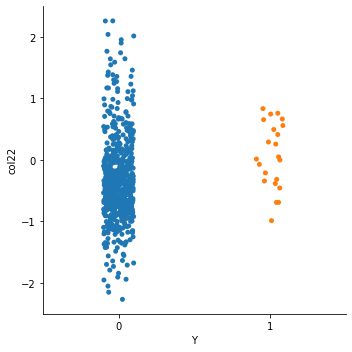

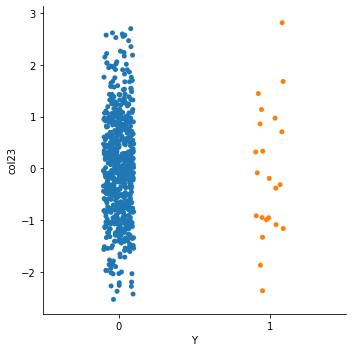

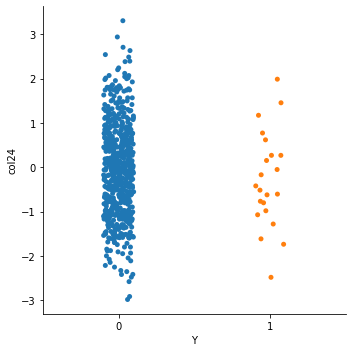

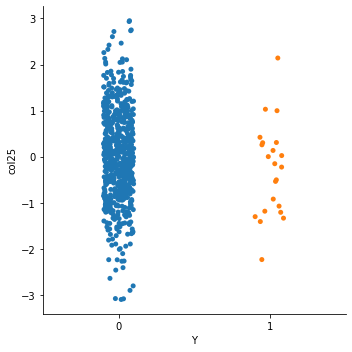

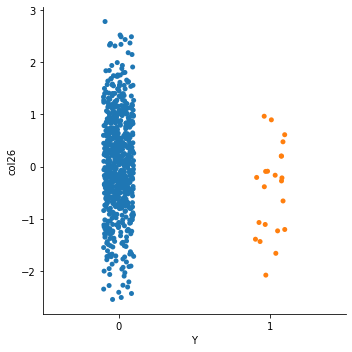

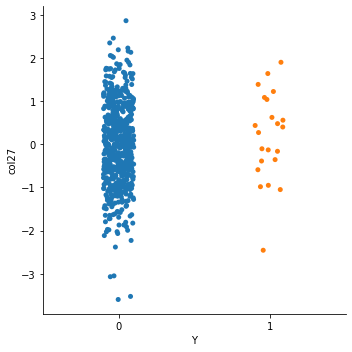

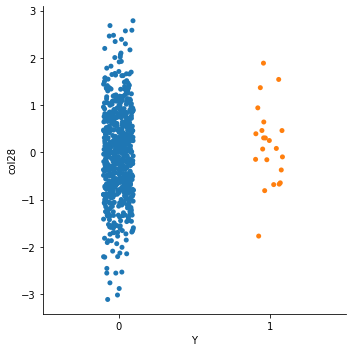

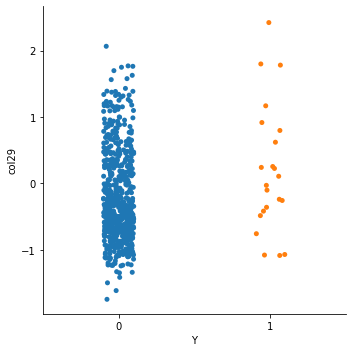

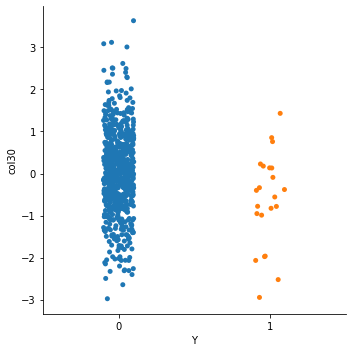

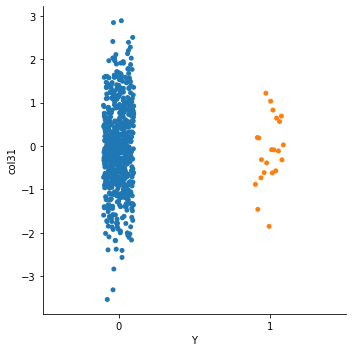

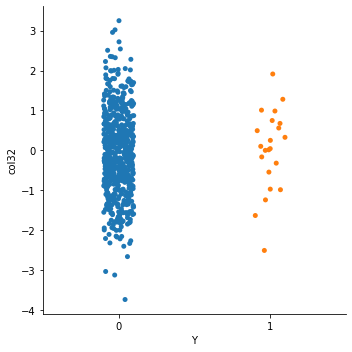

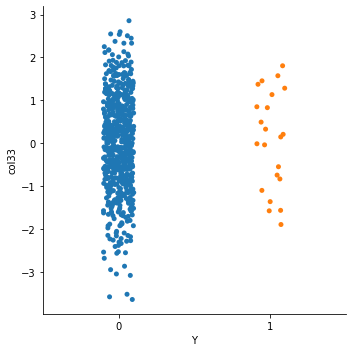

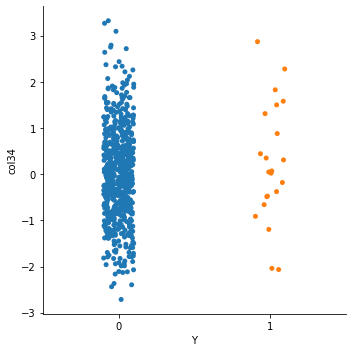

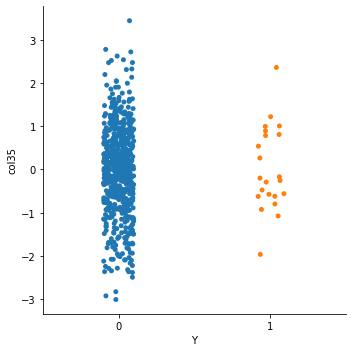

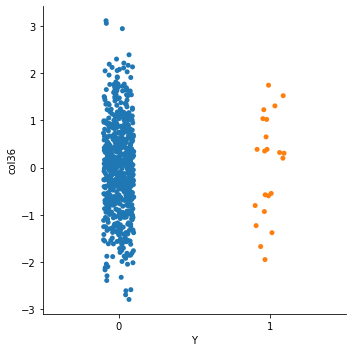

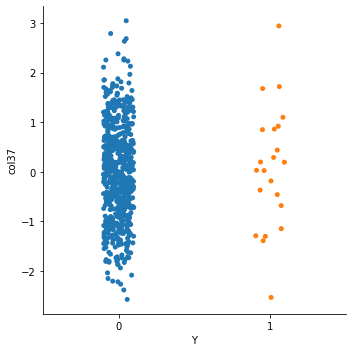

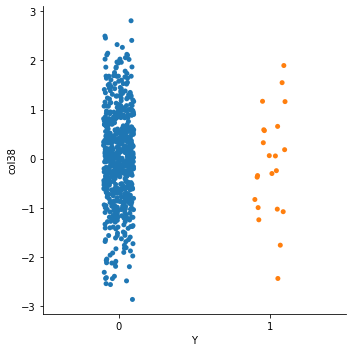

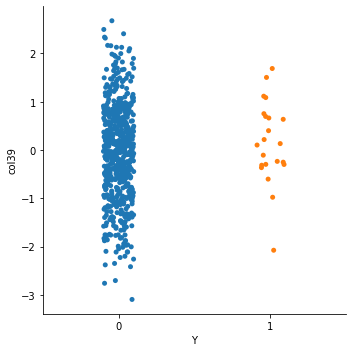

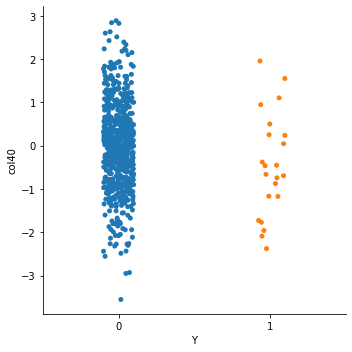

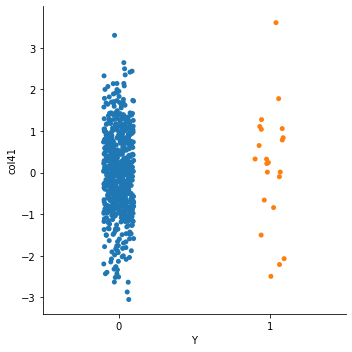

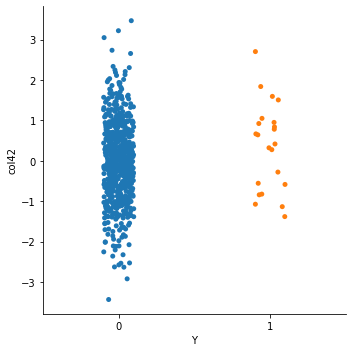

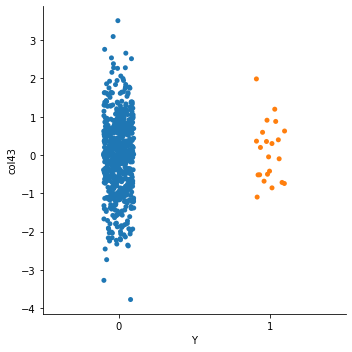

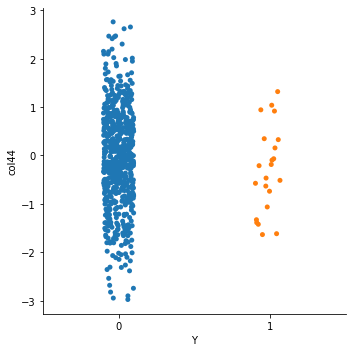

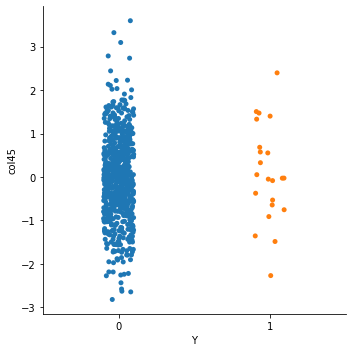

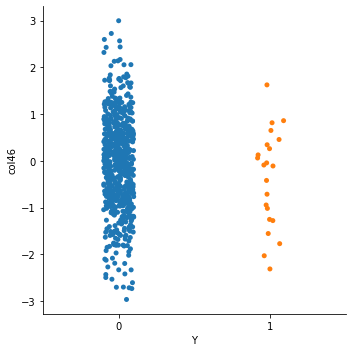

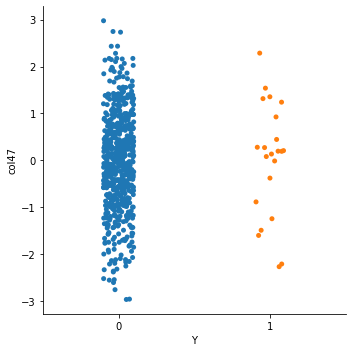

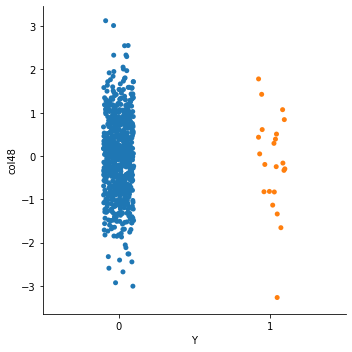

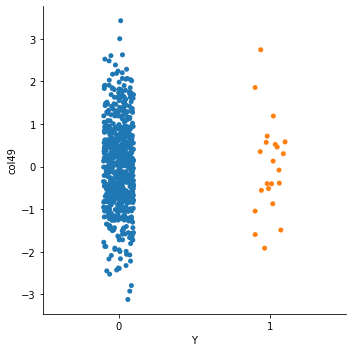

In [34]:
for icol in df_train.columns[:-1]:
    sns.catplot(x='Y', y=icol, data=df_train)

## model training

In [35]:
df_trainX, df_trainY = df_train.iloc[:,:-1], df_train['Y']
df_trainX_SMOTE, df_trainY_SMOTE = df_train_SMOTE.iloc[:,:-1], df_train_SMOTE['Y']

In [36]:
df_test

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,Y
279,-0.469546,0.636822,1.478418,0.105359,0.611442,-0.617234,0.220134,-0.188203,1.067401,-0.711578,...,-0.938391,-0.562628,-0.260209,0.221074,0.493063,-0.036151,0.703123,1.842352,-0.673352,0
643,1.658168,-0.149360,0.408792,1.993685,1.241516,1.300172,-1.114712,0.084104,-0.063785,0.075167,...,-0.369506,-1.355606,0.615659,0.950129,-1.073607,-1.247589,-0.681935,-0.147866,-0.351747,0
287,0.046237,-0.647229,-0.262136,1.048868,0.026947,0.062318,0.719536,-1.194647,-0.988942,-0.564633,...,-0.910515,0.983614,0.137066,0.810702,-1.697901,-0.841642,2.137266,-0.499055,-0.856064,0
36,1.356652,-0.564439,-0.483236,0.432852,-0.427584,0.892363,-0.802413,-0.579789,1.036163,-2.193117,...,-0.759940,-2.534163,0.089462,-0.964190,-1.366425,-0.684165,0.101749,-0.776877,0.629579,0
265,-0.069589,-0.911881,0.483472,-0.703515,-2.300507,1.364939,0.024793,-0.692741,0.065306,-1.468367,...,-0.574988,0.976382,1.946050,-0.967127,0.106720,-1.672445,-0.936009,0.889514,-0.107962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.191675,1.520979,-0.176200,0.850839,-0.298972,0.110356,0.251510,-0.597199,-0.437774,0.373870,...,0.721699,1.388181,-0.503661,0.394835,0.322195,-0.491058,1.982784,-0.690298,-0.904049,0
423,1.671417,-0.104553,-0.356723,0.461165,-0.274861,0.258334,-0.075515,-0.537489,0.543405,-2.321273,...,-0.238230,-0.566348,1.423073,0.697616,-0.435632,1.263094,1.332862,-0.328288,-0.109714,0
630,0.826670,0.459030,-0.585118,0.637934,-0.554042,0.623794,0.846974,-1.764250,-1.582248,2.564070,...,-0.312650,0.027778,-1.294101,-0.301670,0.492400,0.550913,-2.119815,0.432386,0.850422,0
823,0.537397,-1.017016,-0.399569,-1.613423,-0.834271,-1.131539,-0.165629,-0.478617,-1.762229,-1.852343,...,-2.083235,-1.092541,0.282678,-0.708850,0.008555,-0.933078,-1.777044,-1.263728,-1.506463,0


In [37]:
df_train['target_naive1']=df_train['Y'].value_counts().nlargest(n=1).index[0] # most common class
df_train_SMOTE['target_naive1']=df_train_SMOTE['Y'].value_counts().nlargest(n=1).index[0] # most common class

In [38]:
mod_skols = LogisticRegression()
mod_skols.fit(df_trainX,df_trainY)
df_train['target_skols']=mod_skols.predict(df_trainX)
#use SMOTE
mod_skols_SMOTE = LogisticRegression()
mod_skols_SMOTE.fit(df_trainX_SMOTE,df_trainY_SMOTE)
df_train_SMOTE['target_skols']=mod_skols_SMOTE.predict(df_trainX_SMOTE)

In [39]:
mod_lgbm = lightgbm.LGBMClassifier(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df_trainX,df_trainY)
df_train['target_lgbm']=mod_lgbm.predict(df_trainX)
df_train['target_lgbm_p']=mod_lgbm.predict_proba(df_trainX)[:,1]

#use SMOTE
mod_lgbm_SMOTE = lightgbm.LGBMClassifier(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm_SMOTE.fit(df_trainX_SMOTE,df_trainY_SMOTE)
df_train_SMOTE['target_lgbm']=mod_lgbm_SMOTE.predict(df_trainX_SMOTE)
df_train_SMOTE['target_lgbm_p']=mod_lgbm_SMOTE.predict_proba(df_trainX_SMOTE)[:,1] #Return the predicted probability for each class for each sample.


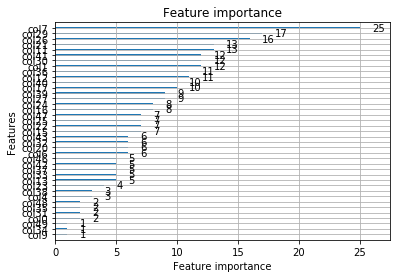

In [40]:
lightgbm.plot_importance(mod_lgbm)

## model evaluation

### prediction errors: in-sample

In [41]:
print('naive class',roc_auc_score(df_train['Y'],df_train['target_naive1']))
print('ols',roc_auc_score(df_train['Y'],df_train['target_skols']))
print('gbm',roc_auc_score(df_train['Y'],df_train['target_lgbm']))

print('naive class SMOTE',roc_auc_score(df_train_SMOTE['Y'],df_train_SMOTE['target_naive1']))
print('ols SMOTE',roc_auc_score(df_train_SMOTE['Y'],df_train_SMOTE['target_skols']))
print('gbm_SMOTE',roc_auc_score(df_train_SMOTE['Y'],df_train_SMOTE['target_lgbm']))

naive class 0.5
ols 0.6348204264870931
gbm 0.9545454545454546
naive class SMOTE 0.5
ols SMOTE 0.9010903426791278
gbm_SMOTE 0.9968847352024922


### prediction errors: cross-validation

In [42]:
print('ols',cross_validate(mod_skols, df_trainX, df_trainY, return_train_score=False, scoring='roc_auc', cv=10)['test_score'].mean())
print('gbm',cross_validate(mod_lgbm, df_trainX, df_trainY, return_train_score=False, scoring='roc_auc', cv=10)['test_score'].mean())

print('ols_SMOTE',cross_validate(mod_skols_SMOTE, df_trainX_SMOTE, df_trainY_SMOTE, return_train_score=False, scoring='roc_auc', cv=10)['test_score'].mean())
print('gbm_with_SMOTE',cross_validate(mod_lgbm_SMOTE, df_trainX_SMOTE, df_trainY_SMOTE, return_train_score=False, scoring='roc_auc', cv=10)['test_score'].mean())


ols 0.6680849358974359
gbm 0.6673237179487179
ols_SMOTE 0.9332560847355769
gbm_with_SMOTE 0.9975559645432692


### prediction errors: out-of-sample

In [43]:
print('ols',roc_auc_score(df_test['Y'],mod_skols.predict(df_test.iloc[:,:-1])))
print('gbm',roc_auc_score(df_test['Y'],mod_lgbm.predict(df_test.iloc[:,:-1])))

print('ols',roc_auc_score(df_test['Y'],mod_skols_SMOTE.predict(df_test.iloc[:,:-1])))
print('gbm_SMOTE',roc_auc_score(df_test['Y'],mod_lgbm_SMOTE.predict(df_test.iloc[:,:-1])))

ols 0.5698805838124723
gbm 0.7857142857142857
ols 0.7237947810703229
gbm_SMOTE 0.7733303847854932


### Classification quality

In [44]:
cfg_thresh = 0.5
print(classification_report((mod_lgbm.predict(df_test.iloc[:,:50])>cfg_thresh).astype(int), df_test['Y']))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       326
           1       0.57      1.00      0.73         4

    accuracy                           0.99       330
   macro avg       0.79      1.00      0.86       330
weighted avg       0.99      0.99      0.99       330



In [45]:
cfg_thresh = 0.5
print(classification_report((mod_lgbm_SMOTE.predict(df_test.iloc[:,:50])>cfg_thresh).astype(int), df_test['Y']))
#by using SMOTE, the predicted 1 increases.

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       318
           1       0.57      0.33      0.42        12

    accuracy                           0.97       330
   macro avg       0.77      0.66      0.70       330
weighted avg       0.96      0.97      0.96       330



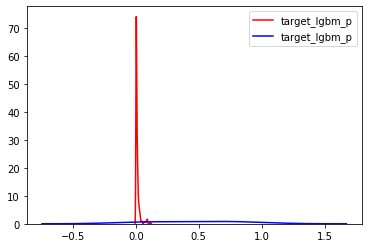

In [46]:
#Without SMOTE
df_test['target_lgbm_p']= mod_lgbm.predict_proba(df_test.iloc[:,:50])[:,1]
sns.kdeplot(df_test.loc[df_test['Y']==0, 'target_lgbm_p'], color="r")
sns.kdeplot(df_test.loc[df_test['Y']==1, 'target_lgbm_p'], color="b")

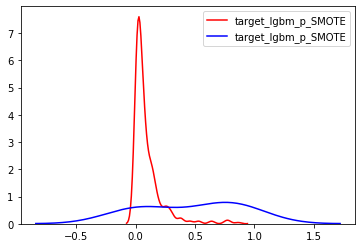

In [47]:
#With SMOTE, the model has higher probability of predicting 1. Model become more smooth.
df_test['target_lgbm_p_SMOTE']= mod_lgbm_SMOTE.predict_proba(df_test.iloc[:,:50])[:,1]
sns.kdeplot(df_test.loc[df_test['Y']==0, 'target_lgbm_p_SMOTE'], color="r")
sns.kdeplot(df_test.loc[df_test['Y']==1, 'target_lgbm_p_SMOTE'], color="b")

## model interpretation

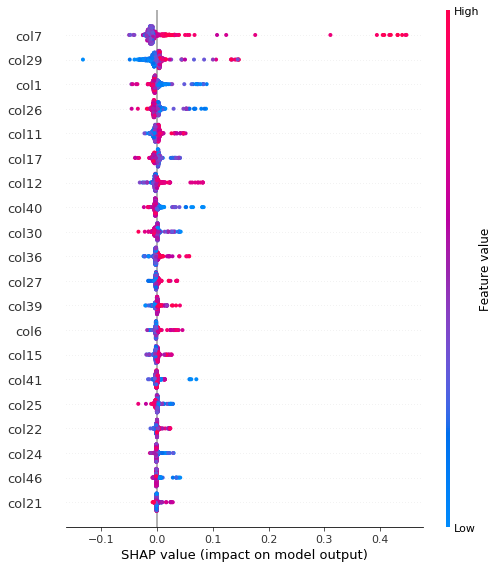

In [48]:
explainer = shap.TreeExplainer(mod_lgbm, df_trainX,model_output="probability")
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)


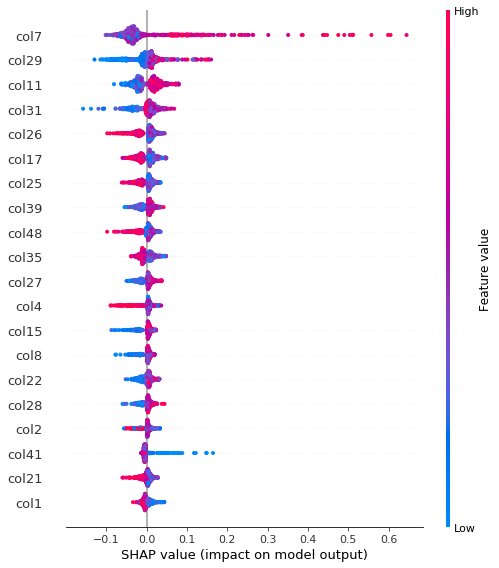

In [49]:
explainer = shap.TreeExplainer(mod_lgbm_SMOTE, df_trainX,model_output="probability")
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)

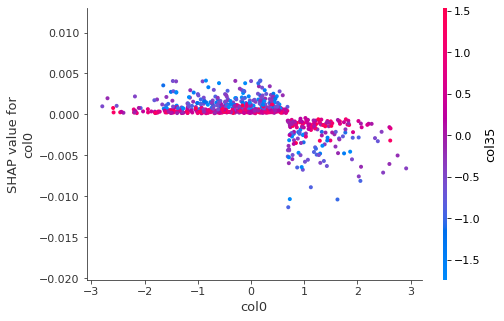

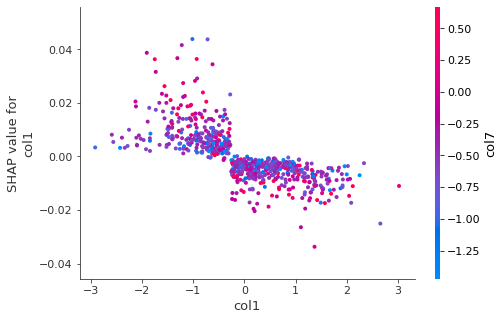

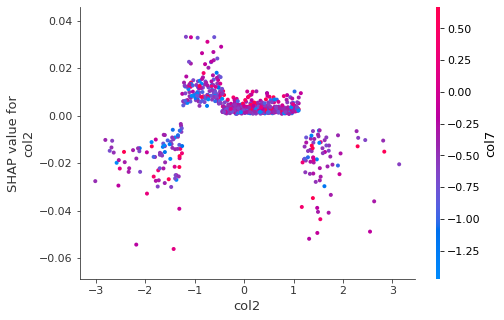

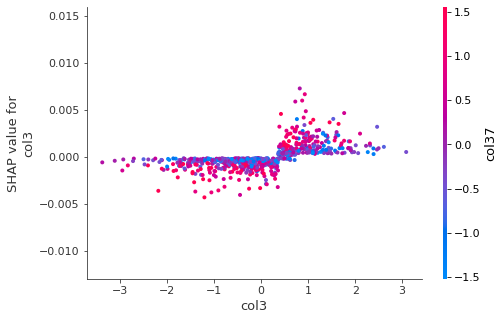

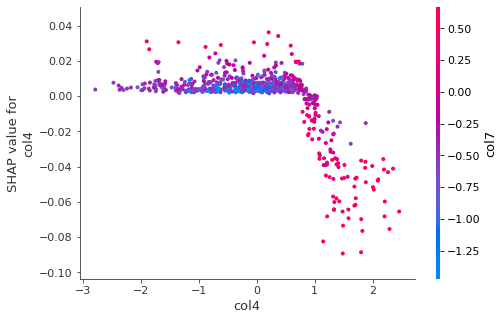

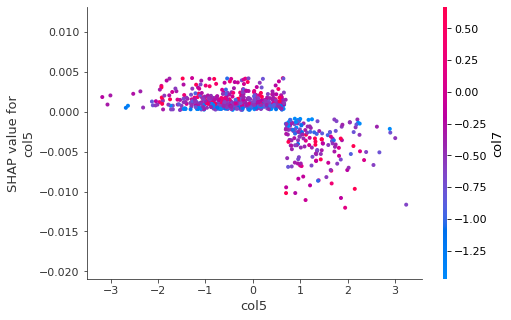

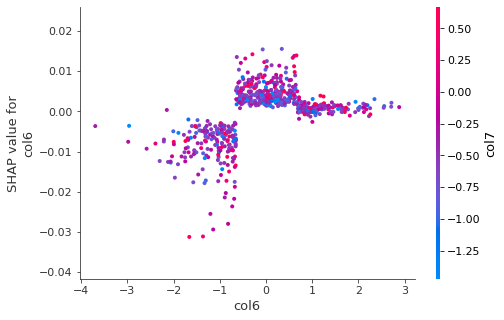

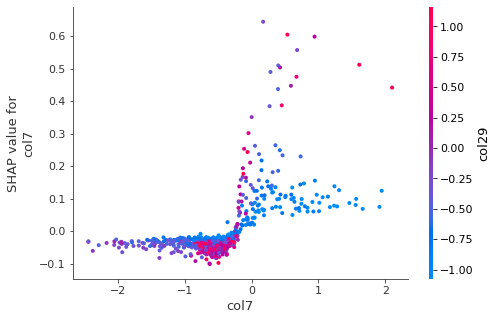

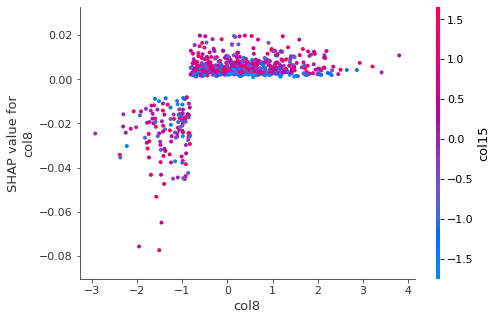

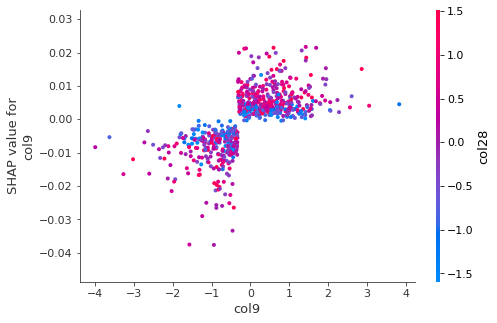

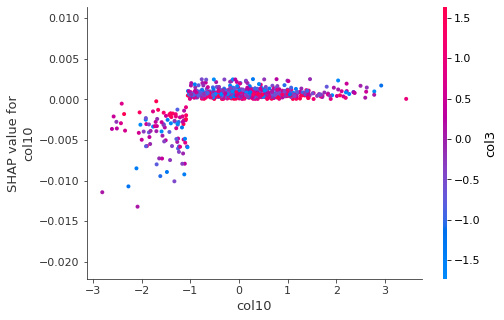

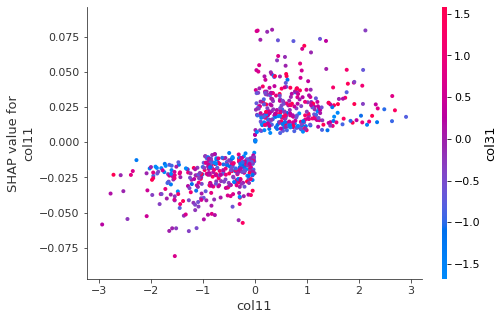

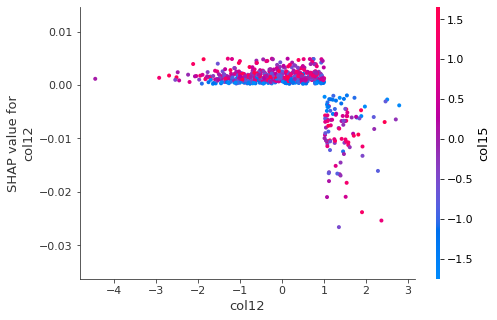

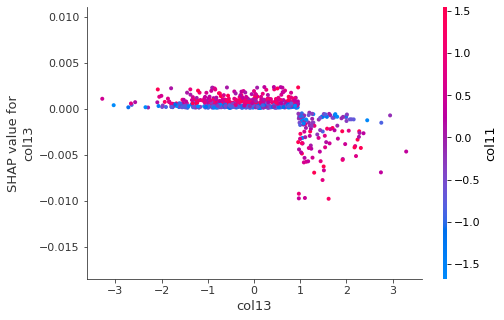

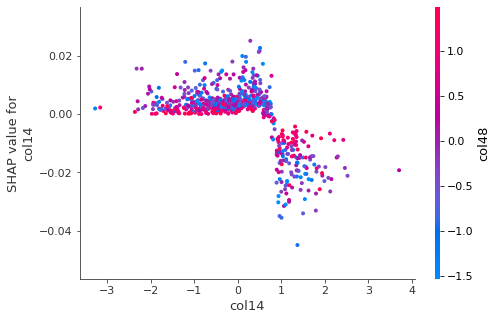

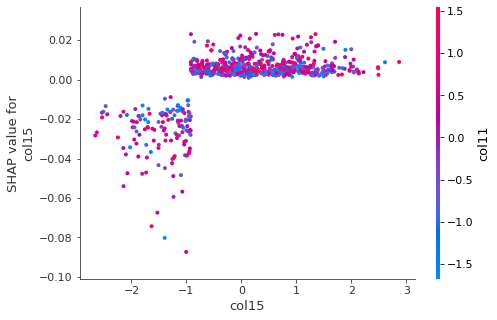

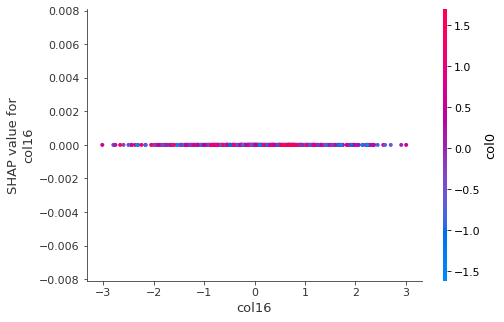

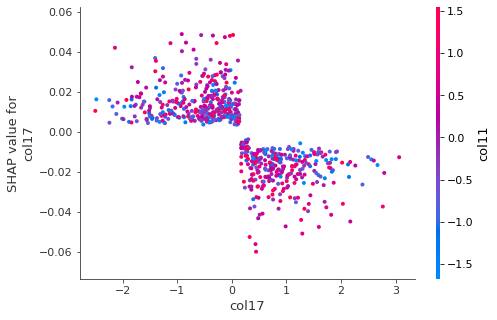

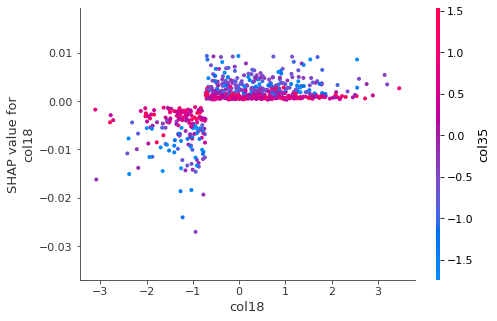

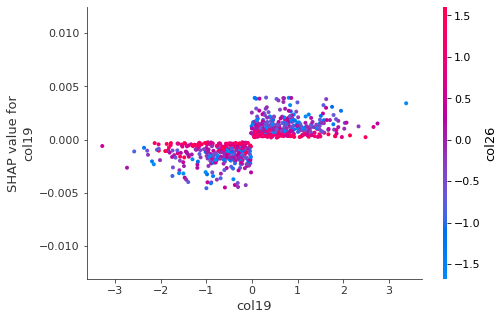

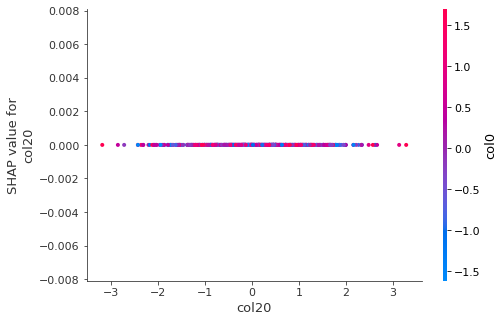

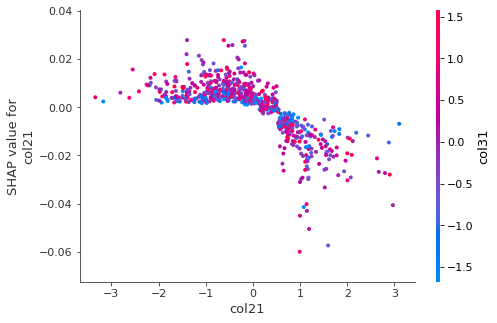

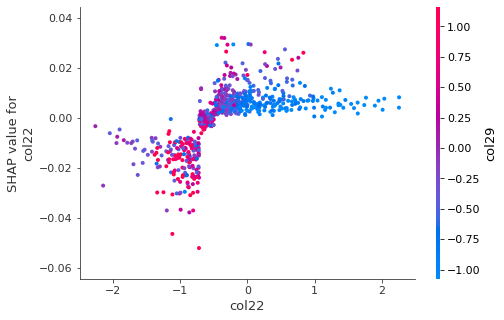

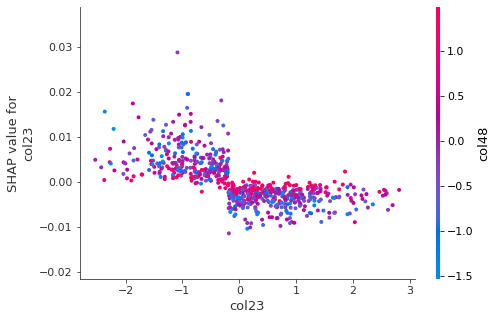

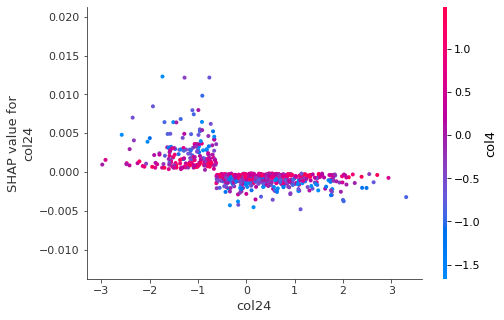

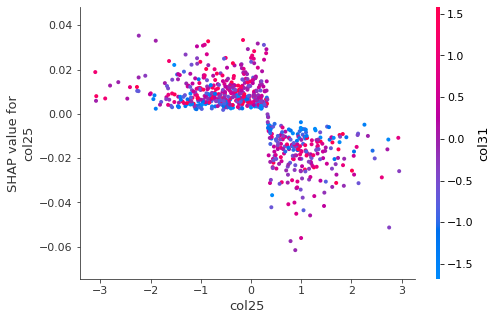

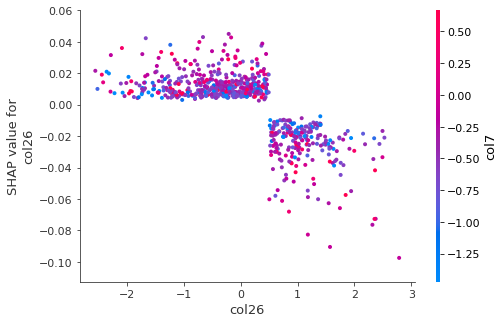

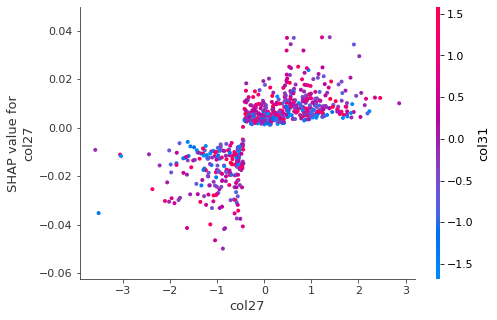

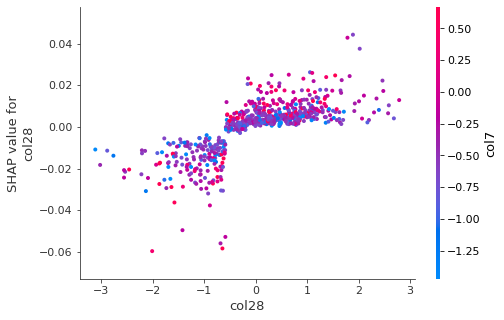

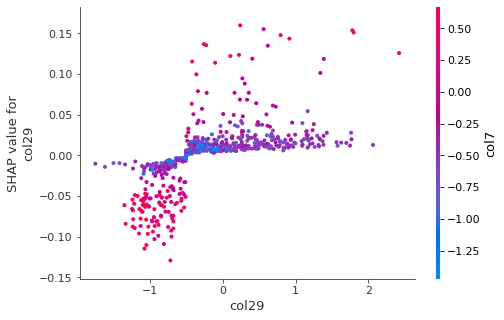

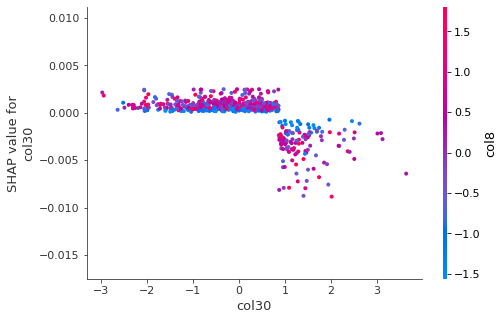

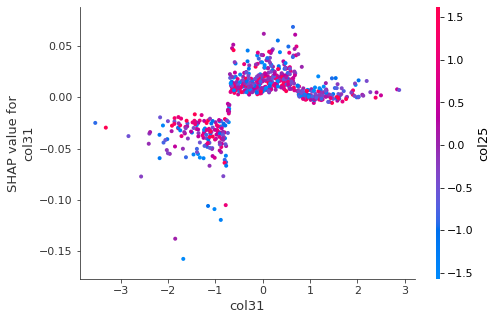

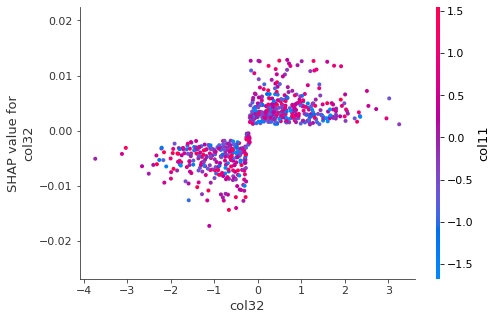

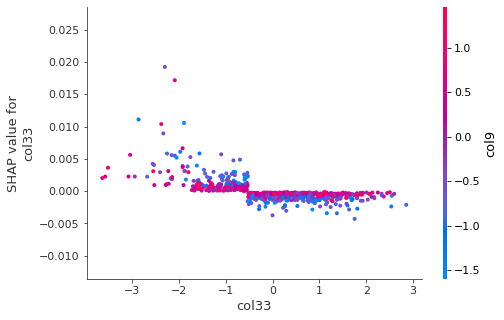

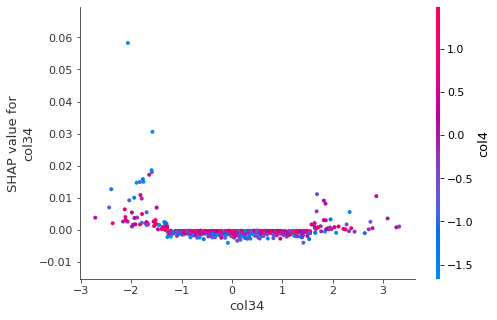

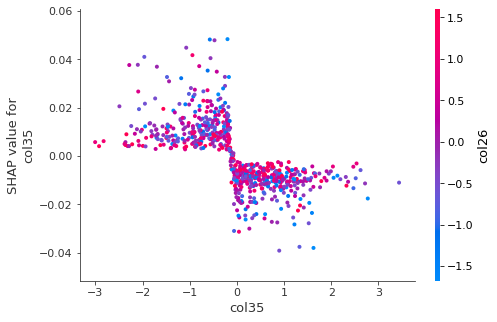

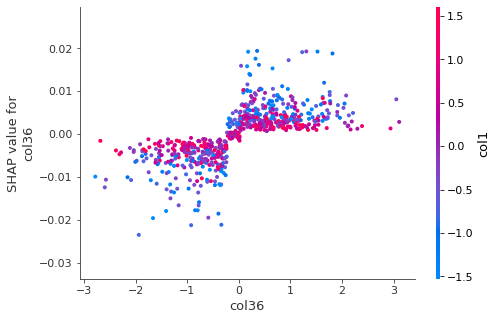

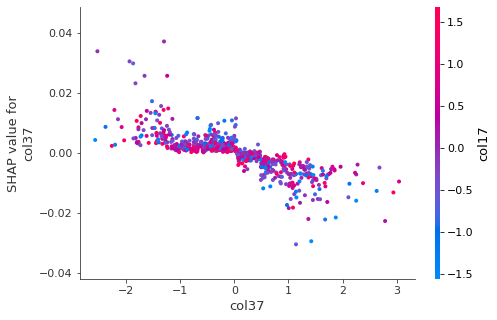

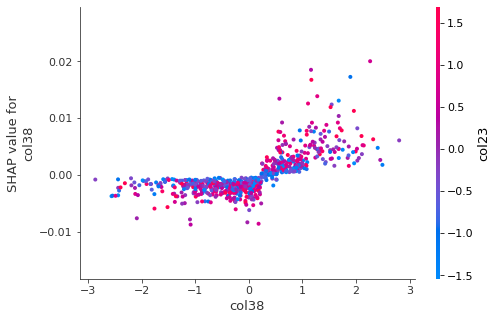

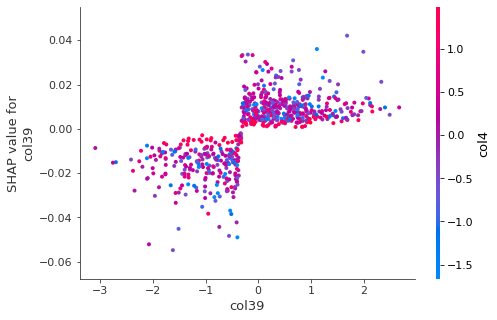

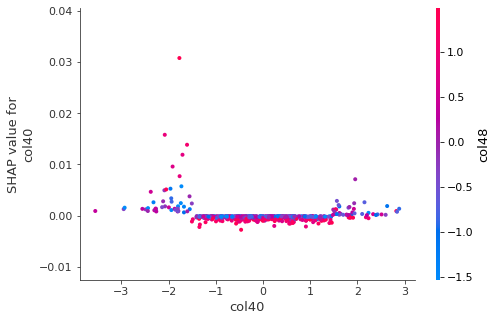

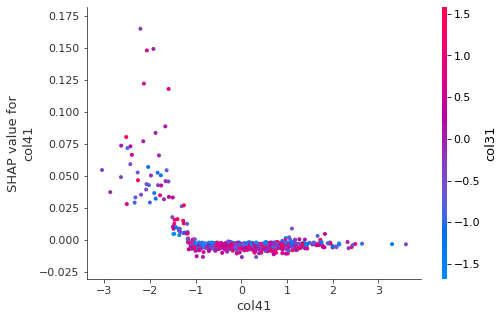

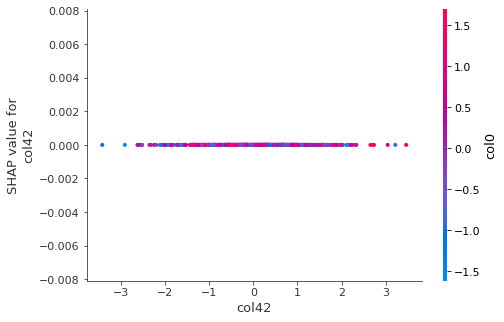

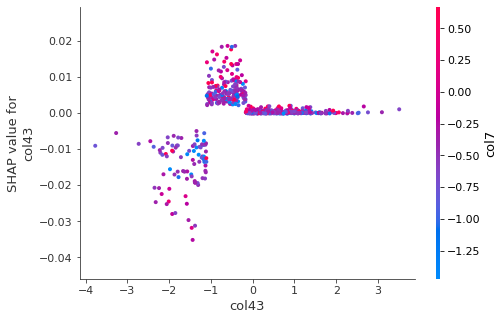

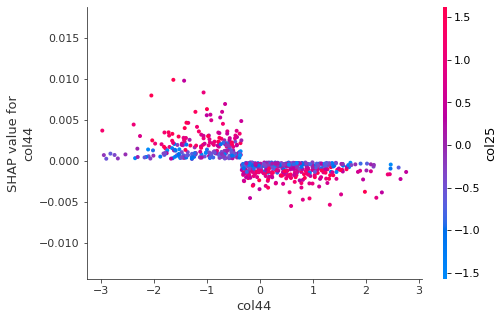

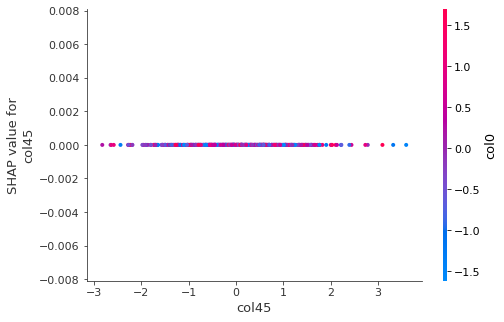

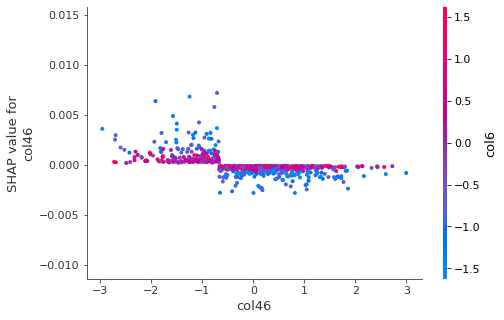

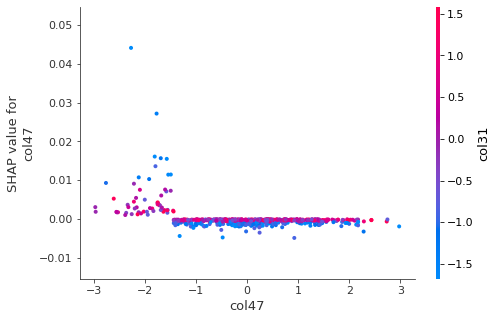

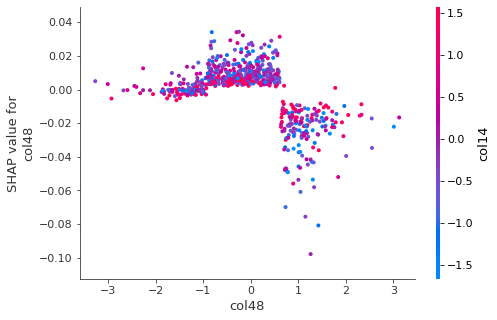

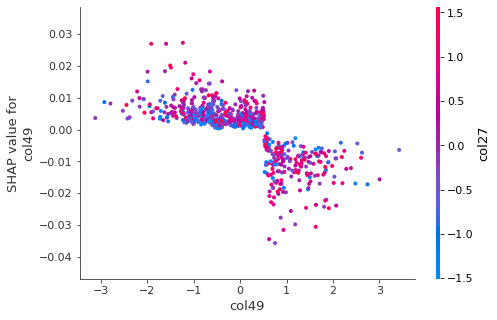

In [50]:
for col in df_trainX.columns[:50]:
    shap.dependence_plot(col, shap_values, df_trainX)#,interaction_index=None)